# 脸部识别
* 人物: Will Ferrell and Chad Smith
* 数据集:pics and cuts
## 步骤
* 1.pics中两位人物的不同图片人脸识别,得到embeddings值,并比较相似度矩阵.
* 2.cuts中两位人物的标注,是否能够正确识别比较.

In [14]:
import os 
import dlib
import openface
import time

start = time.time()
import argparse
import cv2
import pickle
import sys
import pandas as pd
import numpy as np
np.set_printoptions(precision=2)
from sklearn.mixture import GMM
import matplotlib.pyplot as plt
%matplotlib inline

align = openface.AlignDlib("shape_predictor_68_face_landmarks.dat")
net = openface.TorchNeuralNet(
    "/home/lyt/tmpdir/0每日工作/face_recognition/openface/models/openface/nn4.small2.v1.t7",
    imgDim=96)

wf = "data/pics/wf"
cs = "data/pics/cs"
wf = [os.path.join(wf,x) for x in os.listdir(wf)]
cs = [os.path.join(cs,x) for x in os.listdir(cs)]
print(wf)

['data/pics/wf/5.jpeg', 'data/pics/wf/15.jpeg', 'data/pics/wf/6.jpeg', 'data/pics/wf/17.jpeg', 'data/pics/wf/9.jpeg', 'data/pics/wf/16.jpeg', 'data/pics/wf/18.jpeg', 'data/pics/wf/7.jpeg', 'data/pics/wf/3.jpeg', 'data/pics/wf/12.jpeg', 'data/pics/wf/111.jpeg', 'data/pics/wf/19.jpeg', 'data/pics/wf/13.jpeg', 'data/pics/wf/20.jpeg', 'data/pics/wf/2.jpeg', 'data/pics/wf/1.jpeg', 'data/pics/wf/8.jpeg', 'data/pics/wf/10.jpeg', 'data/pics/wf/4.jpeg', 'data/pics/wf/14.jpeg']


In [61]:
def getRep(bgrImg):
    """获得单个图片中人脸的信息"""
    start = time.time()
    if bgrImg is None:
        raise Exception("Unable to load image/frame")

    rgbImg = cv2.cvtColor(bgrImg, cv2.COLOR_BGR2RGB)
    print("  + Original size: {}".format(rgbImg.shape))
    print("Loading the image took {} seconds.".format(time.time() - start))

    start = time.time()

    # Get the largest face bounding box
    # bb = align.getLargestFaceBoundingBox(rgbImg) #Bounding box

    # Get all bounding boxes
    bb = align.getAllFaceBoundingBoxes(rgbImg)

    if bb is None:
        # raise Exception("Unable to find a face: {}".format(imgPath))
        return None
    print("Face detection took {} seconds.".format(time.time() - start))

    start = time.time()

    alignedFaces = []
    for box in bb:
        alignedFaces.append(
            align.align(
                96,
                rgbImg,
                box,
                landmarkIndices=openface.AlignDlib.OUTER_EYES_AND_NOSE))

    if alignedFaces is None:
        raise Exception("Unable to align the frame")
    print("Alignment took {} seconds.".format(time.time() - start))

    start = time.time()

    reps = []
    for alignedFace in alignedFaces:
        reps.append(net.forward(alignedFace))

    print("Neural network forward pass took {} seconds.".format(
        time.time() - start))

    # print (reps)
    return (reps,bb)

def get_embedding(pics):
    """保存所有图片的embedding信息"""
    results = []
    for pic in pics:
        p = cv2.imread(pic)
        (reps,bb)=getRep(p)
        results.append((pic,reps[0],bb[0]))
    return results

def train(df):
    from sklearn import preprocessing
    lb = preprocessing.LabelBinarizer()
    le = lb.fit_transform(df.label)
    gmm = GMM(n_component=2)
    gmm.fit(X=np.array(df.rep.values.tolist())[:-2],y=le)
    gmm.predict(X=[np.array(df.rep.values.tolist())[-1]])
    with open("model/gmm.pkl",'wb') as f:
        pickle.dump(gmm,f)
    return gmm

In [62]:
wf_info = get_embedding(wf)
cs_info = get_embedding(cs)

  + Original size: (225, 225, 3)
Loading the image took 0.0002048015594482422 seconds.
Face detection took 0.031362056732177734 seconds.
Alignment took 0.0035223960876464844 seconds.
Neural network forward pass took 0.18424630165100098 seconds.
  + Original size: (168, 300, 3)
Loading the image took 0.00013136863708496094 seconds.
Face detection took 0.029024124145507812 seconds.
Alignment took 0.004137992858886719 seconds.
Neural network forward pass took 0.1815347671508789 seconds.
  + Original size: (225, 225, 3)
Loading the image took 0.0002040863037109375 seconds.
Face detection took 0.03229665756225586 seconds.
Alignment took 0.004151344299316406 seconds.
Neural network forward pass took 0.18262767791748047 seconds.
  + Original size: (221, 228, 3)
Loading the image took 9.417533874511719e-05 seconds.
Face detection took 0.029870033264160156 seconds.
Alignment took 0.004064083099365234 seconds.
Neural network forward pass took 0.18119072914123535 seconds.
  + Original size: (212,

Neural network forward pass took 0.19723796844482422 seconds.
  + Original size: (232, 218, 3)
Loading the image took 0.00010228157043457031 seconds.
Face detection took 0.031038284301757812 seconds.
Alignment took 0.0039098262786865234 seconds.
Neural network forward pass took 0.20589447021484375 seconds.
  + Original size: (260, 194, 3)
Loading the image took 0.00010132789611816406 seconds.
Face detection took 0.029208660125732422 seconds.
Alignment took 0.004063606262207031 seconds.
Neural network forward pass took 0.1967027187347412 seconds.
  + Original size: (225, 225, 3)
Loading the image took 9.5367431640625e-05 seconds.
Face detection took 0.03241395950317383 seconds.
Alignment took 0.00421142578125 seconds.
Neural network forward pass took 0.1951913833618164 seconds.
  + Original size: (250, 202, 3)
Loading the image took 0.00010180473327636719 seconds.
Face detection took 0.027467966079711914 seconds.
Alignment took 0.0035142898559570312 seconds.
Neural network forward pass 

In [17]:
dflist = []
df = pd.DataFrame(wf_info,columns=['path','rep','bb'])
df.loc[:,"label"]='wf'
dflist.append(df)
df = pd.DataFrame(cs_info,columns=['path','rep','bb'])
df.loc[:,"label"]='cs'
dflist.append(df)
df = pd.concat(dflist)
display(df.head())
display(df.bb.values[0])

,path,rep,bb,label
0,data/pics/wf/5.jpeg,"[-0.00580677762628, 0.198770478368, 0.10192766...","[(32, 56) (139, 163)]",wf
1,data/pics/wf/15.jpeg,"[-0.0192426368594, 0.211933001876, 0.139910683...","[(114, 39) (176, 101)]",wf
2,data/pics/wf/6.jpeg,"[-0.00473290681839, 0.0485695488751, 0.1095911...","[(46, 64) (201, 219)]",wf
3,data/pics/wf/17.jpeg,"[-0.0299610383809, 0.205586612225, 0.079567618...","[(93, 32) (156, 94)]",wf
4,data/pics/wf/9.jpeg,"[0.0242443773896, 0.174277737737, -0.005053708...","[(67, 68) (175, 175)]",wf


rectangle(32,56,139,163)

data/pics/wf/5.jpeg


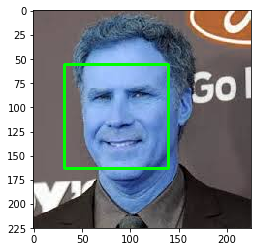

data/pics/wf/15.jpeg


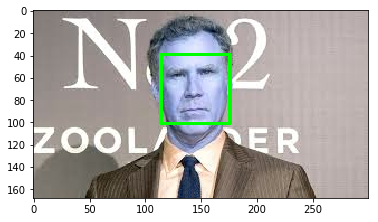

data/pics/wf/6.jpeg


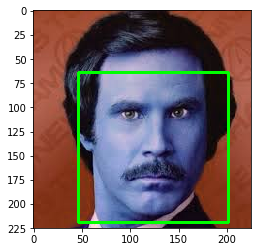

data/pics/wf/17.jpeg


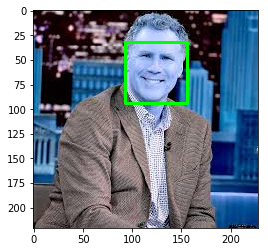

data/pics/wf/9.jpeg


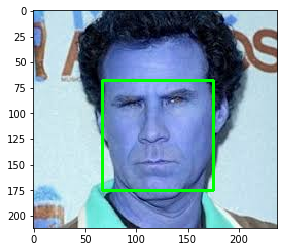

data/pics/wf/16.jpeg


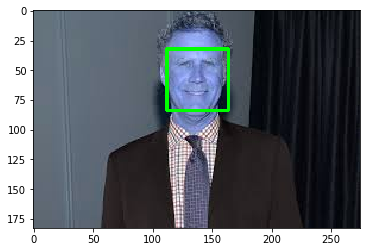

data/pics/wf/18.jpeg


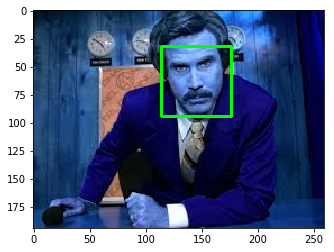

data/pics/wf/7.jpeg


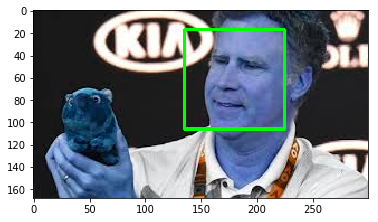

data/pics/wf/3.jpeg


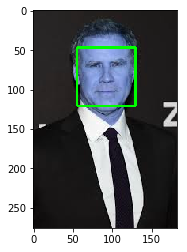

data/pics/wf/12.jpeg


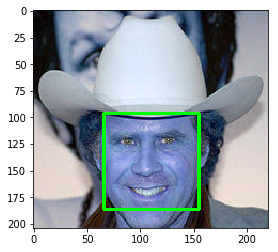

data/pics/wf/111.jpeg


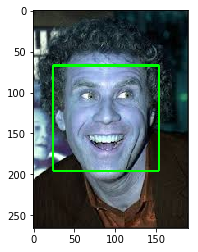

data/pics/wf/19.jpeg


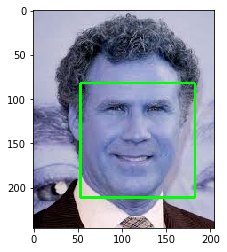

data/pics/wf/13.jpeg


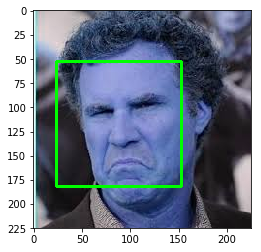

data/pics/wf/20.jpeg


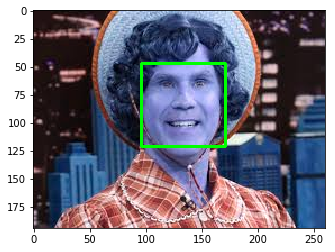

data/pics/wf/2.jpeg


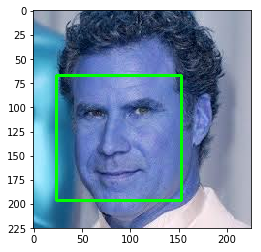

data/pics/wf/1.jpeg


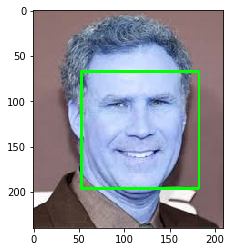

data/pics/wf/8.jpeg


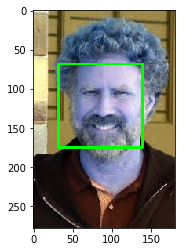

data/pics/wf/10.jpeg


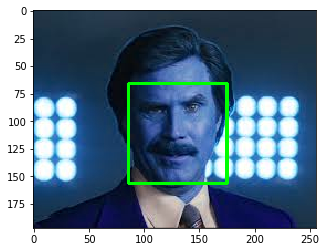

data/pics/wf/4.jpeg


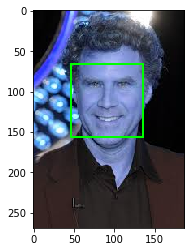

data/pics/wf/14.jpeg


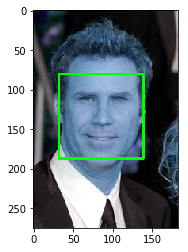

data/pics/cs/5.jpeg


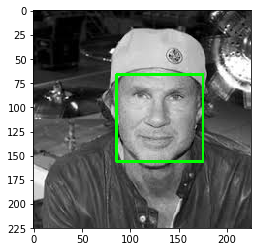

data/pics/cs/15.jpeg


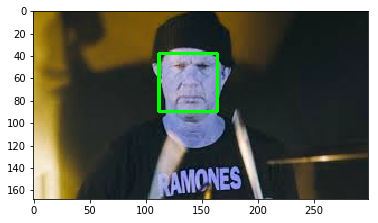

data/pics/cs/6.jpeg


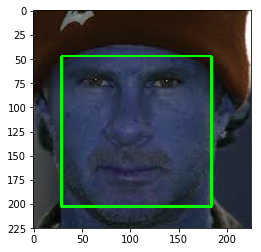

data/pics/cs/17.jpeg


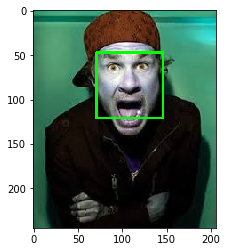

data/pics/cs/9.jpeg


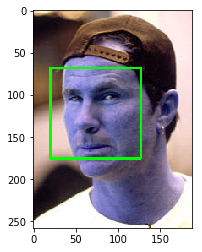

data/pics/cs/16.jpeg


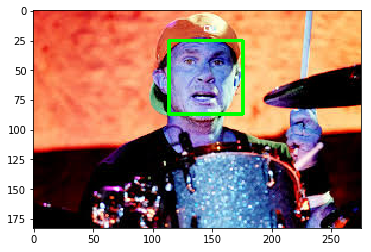

data/pics/cs/18.jpeg


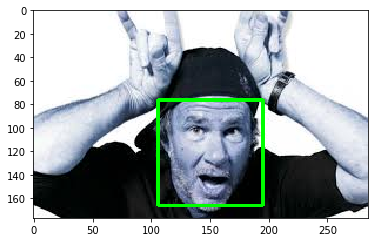

data/pics/cs/7.jpeg


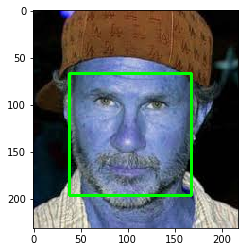

data/pics/cs/3.jpeg


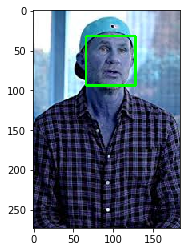

data/pics/cs/12.jpeg


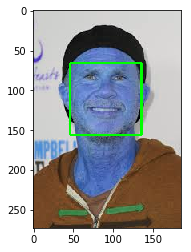

data/pics/cs/19.jpeg


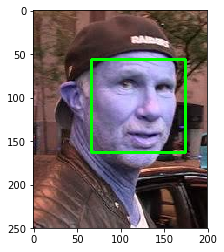

data/pics/cs/13.jpeg


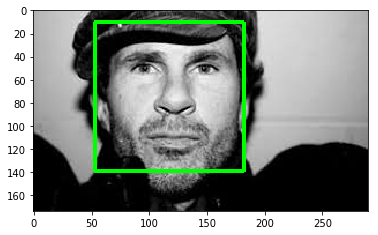

data/pics/cs/20.jpeg


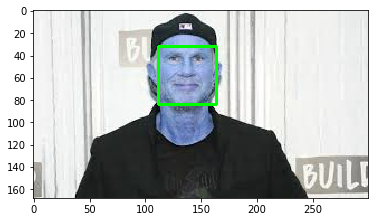

data/pics/cs/2.jpeg


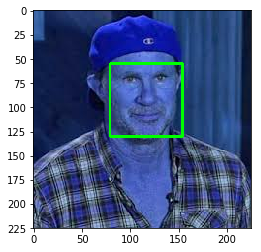

data/pics/cs/11.jpeg


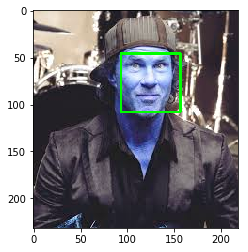

data/pics/cs/1.jpeg


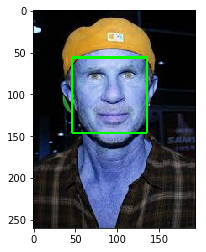

data/pics/cs/8.jpeg


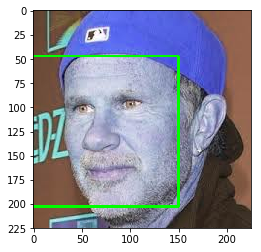

data/pics/cs/10.jpeg


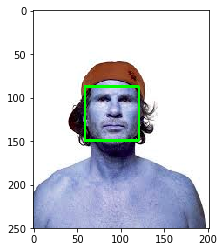

data/pics/cs/4.jpeg


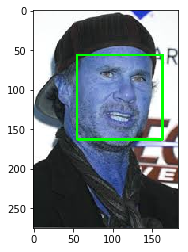

data/pics/cs/14.jpeg


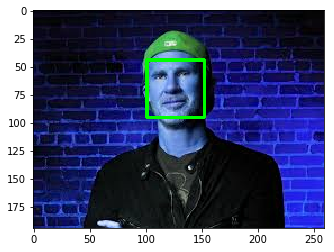

In [67]:
#可视化  bb
for idx,d in df.iterrows():
    print(d.path)
    frame = cv2.imread(d.path)
    bbs = d.bb
    cv2.rectangle(frame, (bbs.left(), bbs.top()), (bbs.right(), bbs.bottom()), (0, 255, 0), 2)

    plt.imshow(frame,cmap='gray')
    plt.show()

In [84]:
# gmm = train(df)
# with open("model/gmm.pkl","rb") as f:
#     gmm = pickle.load(f)
from sklearn.mixture import GaussianMixture
from sklearn.cross_validation import train_test_split
from sklearn import cross_validation
x = np.array(df.rep.tolist())
y = le
tr_x,te_x,tr_y,te_y = train_test_split(x,y,test_size=0.1)
gmm = GaussianMixture(n_components=2,covariance_type="diag")
scores = cross_validation.cross_val_score(gmm,np.array(df.rep.tolist()),le,cv=5, scoring='f1_weighted')
print(scores)
gmm.fit(tr_x,tr_y)
from sklearn.metrics import accuracy_score,f1_score
print(te_x.shape)
print(gmm.predict_proba(te_x))
print("gmm score  ",accuracy_score(np.argmax(gmm.predict_proba(te_x),axis=1),te_y))
from sklearn.decomposition import PCA
# pca = PCA(n_components=2)
# x = pca.fit_transform(x)
from sklearn.svm import LinearSVC
clf = LinearSVC()
clf.fit(tr_x,tr_y)
print(clf.predict(te_x))
print("f1 score ",f1_score(clf.predict(te_x),te_y))

[ 1.    0.67  0.62  0.    0.93]
(4, 128)
[[  1.69e-07   1.00e+00]
 [  1.00e+00   8.54e-51]
 [  1.42e-32   1.00e+00]
 [  2.41e-19   1.00e+00]]
gmm score   1.0
[1 0 1 1]
f1 score  1.0


/home/ll/miniconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/ll/miniconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ll/miniconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/ll/miniconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/ll/miniconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:578

In [86]:
with open("model/modelandle.pkl",'wb') as f:
    pickle.dump([lb,clf,gmm],f)
lb,clf,gmm = pickle.load(open("model/modelandle.pkl",'rb'))
print(lb)
print(clf)

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)


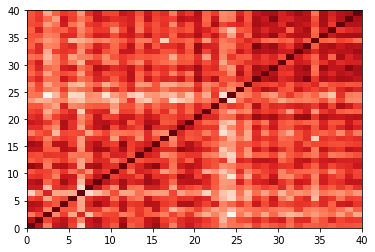

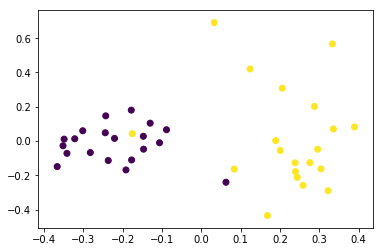

In [27]:
from sklearn.metrics.pairwise import cosine_similarity
asim = cosine_similarity(np.array(df.rep.tolist()))
import matplotlib.pyplot as plt
%matplotlib inline
Index= df.bb.values
Cols = df.bb.values

plt.pcolor(asim,cmap=plt.cm.Reds)
# plt.yticks(np.arange(0.5, len(asim), 1), asim)
# plt.xticks(np.arange(0.5, len(asim), 1), asim)
plt.show()
from sklearn.decomposition import PCA
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
le = lb.fit_transform(df.label)
pca = PCA(n_components=2)
asim1 = pca.fit_transform(np.array(df.rep.tolist()))
plt.scatter(x=asim1[:,0],y=asim1[:,1],c=le)

# 结论
* 使用svm分类效果好

In [66]:
def infer(img):
    """得到图片中所有人物"""
    with open("model/modelandle.pkl", 'rb') as f:
        (le, clf,gmm) = pickle.load(f)  # le - label and clf - classifer
    repsAndBBs = getRep(img)
    reps = repsAndBBs[0]
    bbs = repsAndBBs[1]
    persons = []
    confidences = []
    for rep in reps:
        try:
            rep = rep.reshape(1, -1)
        except:
            print ("No Face detected")
            return (None, None)
        start = time.time()
        predictions = clf.predict(rep).ravel()
        print (predictions)
        persons.append(le.inverse_transform(np.array(predictions)))
    return (persons,bbs)

frames = [os.path.join("data/cuts",x) for x in os.listdir("data/cuts/")]
for pic in frames:
    frame = cv2.imread(pic)
    persons,bbs = infer(frame)
    print(len(persons),len(bbs))
    for idx,person in enumerate(persons):
        cv2.rectangle(frame, (bbs[idx].left(), bbs[idx].top()), (bbs[idx].right(), bbs[idx].bottom()), (0, 255, 0), 2)
        cv2.putText(frame, "{}".format(person),
                    (bbs[idx].left(), bbs[idx].bottom()+20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

    cv2.imwrite(os.path.join("data/cuts_lb/",pic.split("/")[-1]),frame)

  + Original size: (360, 640, 3)
Loading the image took 0.0002181529998779297 seconds.
Face detection took 0.11927437782287598 seconds.
Alignment took 0.006479024887084961 seconds.
Neural network forward pass took 0.3645174503326416 seconds.
[1]
[1]
2 2
  + Original size: (360, 640, 3)
Loading the image took 0.00016450881958007812 seconds.
Face detection took 0.11617088317871094 seconds.
Alignment took 0.004182338714599609 seconds.
Neural network forward pass took 0.18326473236083984 seconds.
[1]
1 1
  + Original size: (360, 640, 3)
Loading the image took 0.00017404556274414062 seconds.
Face detection took 0.11492228507995605 seconds.
Alignment took 0.007416248321533203 seconds.
Neural network forward pass took 0.3961002826690674 seconds.
[1]
[1]
2 2
  + Original size: (360, 640, 3)
Loading the image took 0.0002586841583251953 seconds.
Face detection took 0.12175726890563965 seconds.
Alignment took 0.013151884078979492 seconds.
Neural network forward pass took 0.5863046646118164 second

Neural network forward pass took 0.3721461296081543 seconds.
[0]
[0]
2 2
  + Original size: (360, 640, 3)
Loading the image took 0.00026297569274902344 seconds.
Face detection took 0.12330460548400879 seconds.
Alignment took 0.006886720657348633 seconds.
Neural network forward pass took 0.3714125156402588 seconds.
[1]
[1]
2 2
  + Original size: (360, 640, 3)
Loading the image took 0.0002853870391845703 seconds.
Face detection took 0.12187743186950684 seconds.
Alignment took 0.006989717483520508 seconds.
Neural network forward pass took 0.36768078804016113 seconds.
[0]
[1]
2 2
  + Original size: (360, 640, 3)
Loading the image took 0.0002048015594482422 seconds.
Face detection took 0.1146235466003418 seconds.
Alignment took 0.009786128997802734 seconds.
Neural network forward pass took 0.5526330471038818 seconds.
[1]
[0]
[0]
3 3
  + Original size: (360, 640, 3)
Loading the image took 0.0002567768096923828 seconds.
Face detection took 0.1309809684753418 seconds.
Alignment took 0.00816631

Neural network forward pass took 0.37111902236938477 seconds.
[1]
[1]
2 2
  + Original size: (360, 640, 3)
Loading the image took 0.00029587745666503906 seconds.
Face detection took 0.11643004417419434 seconds.
Alignment took 0.006641387939453125 seconds.
Neural network forward pass took 0.3742387294769287 seconds.
[0]
[1]
2 2
  + Original size: (360, 640, 3)
Loading the image took 0.00027441978454589844 seconds.
Face detection took 0.11588835716247559 seconds.
Alignment took 0.010138511657714844 seconds.
Neural network forward pass took 0.5480272769927979 seconds.
[1]
[0]
[1]
3 3
  + Original size: (360, 640, 3)
Loading the image took 0.00023865699768066406 seconds.
Face detection took 0.11868500709533691 seconds.
Alignment took 0.006806612014770508 seconds.
Neural network forward pass took 0.4013514518737793 seconds.
[1]
[0]
2 2
  + Original size: (360, 640, 3)
Loading the image took 0.00020742416381835938 seconds.
Face detection took 0.12873530387878418 seconds.
Alignment took 0.007

Neural network forward pass took 0.5542261600494385 seconds.
[0]
[1]
[1]
3 3
  + Original size: (360, 640, 3)
Loading the image took 0.00019812583923339844 seconds.
Face detection took 0.11393356323242188 seconds.
Alignment took 0.009708166122436523 seconds.
Neural network forward pass took 0.5476436614990234 seconds.
[1]
[1]
[1]
3 3
  + Original size: (360, 640, 3)
Loading the image took 0.00019693374633789062 seconds.
Face detection took 0.12383294105529785 seconds.
Alignment took 0.006447315216064453 seconds.
Neural network forward pass took 0.3660461902618408 seconds.
[1]
[1]
2 2
  + Original size: (360, 640, 3)
Loading the image took 0.0002696514129638672 seconds.
Face detection took 0.11393404006958008 seconds.
Alignment took 0.010556697845458984 seconds.
Neural network forward pass took 0.5487375259399414 seconds.
[0]
[1]
[1]
3 3
  + Original size: (360, 640, 3)
Loading the image took 0.00019788742065429688 seconds.
Face detection took 0.11409711837768555 seconds.
Alignment took

Neural network forward pass took 0.5554265975952148 seconds.
[0]
[1]
[1]
3 3
  + Original size: (360, 640, 3)
Loading the image took 0.0002663135528564453 seconds.
Face detection took 0.11872220039367676 seconds.
Alignment took 0.009261846542358398 seconds.
Neural network forward pass took 0.5459990501403809 seconds.
[1]
[1]
[0]
3 3
  + Original size: (360, 640, 3)
Loading the image took 0.00025653839111328125 seconds.
Face detection took 0.11400938034057617 seconds.
Alignment took 0.0066051483154296875 seconds.
Neural network forward pass took 0.36885905265808105 seconds.
[0]
[1]
2 2
  + Original size: (360, 640, 3)
Loading the image took 0.0002677440643310547 seconds.
Face detection took 0.11423444747924805 seconds.
Alignment took 0.006745576858520508 seconds.
Neural network forward pass took 0.36478090286254883 seconds.
[0]
[1]
2 2
  + Original size: (360, 640, 3)
Loading the image took 0.0002627372741699219 seconds.
Face detection took 0.11394166946411133 seconds.
Alignment took 0.

Neural network forward pass took 0.3637866973876953 seconds.
[0]
[1]
2 2
  + Original size: (360, 640, 3)
Loading the image took 0.0001926422119140625 seconds.
Face detection took 0.1137242317199707 seconds.
Alignment took 0.003501415252685547 seconds.
Neural network forward pass took 0.18406367301940918 seconds.
[0]
1 1
  + Original size: (360, 640, 3)
Loading the image took 0.00022482872009277344 seconds.
Face detection took 0.1154472827911377 seconds.
Alignment took 0.007144451141357422 seconds.
Neural network forward pass took 0.36459827423095703 seconds.
[1]
[1]
2 2
  + Original size: (360, 640, 3)
Loading the image took 0.0002617835998535156 seconds.
Face detection took 0.11342215538024902 seconds.
Alignment took 0.006016731262207031 seconds.
Neural network forward pass took 0.3674759864807129 seconds.
[1]
[0]
2 2
  + Original size: (360, 640, 3)
Loading the image took 0.0002932548522949219 seconds.
Face detection took 0.11521029472351074 seconds.
Alignment took 0.006738185882568

Neural network forward pass took 0.5534944534301758 seconds.
[0]
[1]
[1]
3 3
  + Original size: (360, 640, 3)
Loading the image took 0.00020313262939453125 seconds.
Face detection took 0.12017607688903809 seconds.
Alignment took 0.0059435367584228516 seconds.
Neural network forward pass took 0.3665156364440918 seconds.
[1]
[0]
2 2
  + Original size: (360, 640, 3)
Loading the image took 0.00027441978454589844 seconds.
Face detection took 0.11348509788513184 seconds.
Alignment took 0.006618499755859375 seconds.
Neural network forward pass took 0.36853599548339844 seconds.
[1]
[0]
2 2
  + Original size: (360, 640, 3)
Loading the image took 0.00028967857360839844 seconds.
Face detection took 0.11496162414550781 seconds.
Alignment took 0.010907649993896484 seconds.
Neural network forward pass took 0.5459866523742676 seconds.
[1]
[0]
[1]
3 3


In [ ]:
#!/usr/bin/env python2
#
# Example to run classifier on webcam stream.
# Brandon Amos & Vijayenthiran
# 2016/06/21
#
# Copyright 2015-2016 Carnegie Mellon University
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Contrib: Vijayenthiran
# This example file shows to run a classifier on webcam stream. You need to
# run the classifier.py to generate classifier with your own dataset.
# To run this file from the openface home dir:
# ./demo/classifier_webcam.py <path-to-your-classifier>


import time

start = time.time()

import argparse
import cv2
import os
import pickle
import sys

import numpy as np
np.set_printoptions(precision=2)
from sklearn.mixture import GMM
import openface

fileDir = "/home/lyt/tmpdir/0每日工作/face_recognition/openface/demos/"
modelDir = os.path.join(fileDir, '..', 'models')
dlibModelDir = os.path.join(modelDir, 'dlib')
openfaceModelDir = os.path.join(modelDir, 'openface')


def getRep(bgrImg):
    start = time.time()
    if bgrImg is None:
        raise Exception("Unable to load image/frame")

    rgbImg = cv2.cvtColor(bgrImg, cv2.COLOR_BGR2RGB)
    print("  + Original size: {}".format(rgbImg.shape))
    print("Loading the image took {} seconds.".format(time.time() - start))

    start = time.time()

    # Get the largest face bounding box
    # bb = align.getLargestFaceBoundingBox(rgbImg) #Bounding box

    # Get all bounding boxes
    bb = align.getAllFaceBoundingBoxes(rgbImg)

    if bb is None:
        # raise Exception("Unable to find a face: {}".format(imgPath))
        return None
    print("Face detection took {} seconds.".format(time.time() - start))

    start = time.time()

    alignedFaces = []
    for box in bb:
        alignedFaces.append(
            align.align(
                96,
                rgbImg,
                box,
                landmarkIndices=openface.AlignDlib.OUTER_EYES_AND_NOSE))

    if alignedFaces is None:
        raise Exception("Unable to align the frame")
    print("Alignment took {} seconds.".format(time.time() - start))

    start = time.time()

    reps = []
    for alignedFace in alignedFaces:
        reps.append(net.forward(alignedFace))

    print("Neural network forward pass took {} seconds.".format(
        time.time() - start))

    # print (reps)
    return (reps,bb)


def infer(img, args):
    with open(args.classifierModel, 'r') as f:
        if sys.version_info[0] < 3:
                (le, clf) = pickle.load(f)  # le - label and clf - classifer
        else:
                (le, clf) = pickle.load(f, encoding='latin1')  # le - label and clf - classifer

    repsAndBBs = getRep(img)
    reps = repsAndBBs[0]
    bbs = repsAndBBs[1]
    persons = []
    confidences = []
    for rep in reps:
        try:
            rep = rep.reshape(1, -1)
        except:
            print ("No Face detected")
            return (None, None)
        start = time.time()
        predictions = clf.predict_proba(rep).ravel()
        # print (predictions)
        maxI = np.argmax(predictions)
        # max2 = np.argsort(predictions)[-3:][::-1][1]
        persons.append(le.inverse_transform(maxI))
        # print (str(le.inverse_transform(max2)) + ": "+str( predictions [max2]))
        # ^ prints the second prediction
        confidences.append(predictions[maxI])
        if args.verbose:
            print("Prediction took {} seconds.".format(time.time() - start))
            pass
        # print("Predict {} with {:.2f} confidence.".format(person.decode('utf-8'), confidence))
        if isinstance(clf, GMM):
            dist = np.linalg.norm(rep - clf.means_[maxI])
            print("  + Distance from the mean: {}".format(dist))
            pass
    return (persons, confidences ,bbs)


parser = argparse.ArgumentParser()
parser.add_argument(
    '--dlibFacePredictor',
    type=str,
    help="Path to dlib's face predictor.",
    default=os.path.join(
        dlibModelDir,
        "shape_predictor_68_face_landmarks.dat"))
parser.add_argument(
    '--networkModel',
    type=str,
    help="Path to Torch network model.",
    default=os.path.join(
        openfaceModelDir,
        'nn4.small2.v1.t7'))
parser.add_argument('--imgDim', type=int,
                    help="Default image dimension.", default=96)
parser.add_argument(
    '--captureDevice',
    type=int,
    default=0,
    help='Capture device. 0 for latop webcam and 1 for usb webcam')
parser.add_argument('--width', type=int, default=320)
parser.add_argument('--height', type=int, default=240)
parser.add_argument('--threshold', type=float, default=0.5)
parser.add_argument('--cuda', action='store_true')
parser.add_argument('--verbose', action='store_true')
parser.add_argument(
    'classifierModel',
    type=str,
    help='The Python pickle representing the classifier. This is NOT the Torch network model, which can be set with --networkModel.')

args = parser.parse_args()

align = openface.AlignDlib("shape_predictor_68_face_landmarks.dat")
net = openface.TorchNeuralNet(
    "/home/lyt/tmpdir/0每日工作/face_recognition/openface/models/openface/nn4.small2.v1.t7",
    imgDim=96)

# Capture device. Usually 0 will be webcam and 1 will be usb cam.
video_capture = cv2.VideoCapture(args.captureDevice)
video_capture.set(3, args.width)
video_capture.set(4, args.height)

confidenceList = []
while True:
    ret, frame = video_capture.read()
    persons, confidences, bbs = infer(frame, args)
    print ("P: " + str(persons) + " C: " + str(confidences))
    try:
        # append with two floating point precision
        confidenceList.append('%.2f' % confidences[0])
    except:
        # If there is no face detected, confidences matrix will be empty.
        # We can simply ignore it.
        pass

    for i, c in enumerate(confidences):
        if c <= args.threshold:  # 0.5 is kept as threshold for known face.
            persons[i] = "_unknown"

    # Print the person name and conf value on the frame next to the person
    # Also print the bounding box
    for idx,person in enumerate(persons):
        cv2.rectangle(frame, (bbs[idx].left(), bbs[idx].top()), (bbs[idx].right(), bbs[idx].bottom()), (0, 255, 0), 2)
        cv2.putText(frame, "{} @{:.2f}".format(person, confidences[idx]),
                    (bbs[idx].left(), bbs[idx].bottom()+20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

    cv2.imshow('', frame)
    # quit the program on the press of key 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
# When everything is done, release the capture
video_capture.release()
cv2.destroyAllWindows()

In [5]:
pic = cv2.imread("step2_2b.jpg")
(reps,bb)=getRep(pic)

  + Original size: (293, 720, 3)
Loading the image took 0.0036973953247070312 seconds.
Face detection took 0.10880160331726074 seconds.
Alignment took 0.02343893051147461 seconds.
Neural network forward pass took 0.3758113384246826 seconds.


In [7]:
repsAndBBs = getRep(pic)
reps = repsAndBBs[0]
bbs = repsAndBBs[1]
persons = []
confidences = []
for rep in reps:
    try:
        rep = rep.reshape(1, -1)
    except:
        print ("No Face detected")
        return (None, None)
    start = time.time()
    predictions = clf.predict_proba(rep).ravel()
    # print (predictions)
    maxI = np.argmax(predictions)
    # max2 = np.argsort(predictions)[-3:][::-1][1]
    persons.append(le.inverse_transform(maxI))
    # print (str(le.inverse_transform(max2)) + ": "+str( predictions [max2]))
    # ^ prints the second prediction
    confidences.append(predictions[maxI])
    if args.verbose:
        print("Prediction took {} seconds.".format(time.time() - start))
        pass
    # print("Predict {} with {:.2f} confidence.".format(person.decode('utf-8'), confidence))
    if isinstance(clf, GMM):
        dist = np.linalg.norm(rep - clf.means_[maxI])
        print("  + Distance from the mean: {}".format(dist))
        pass

rectangles[[(38, 110) (167, 239)], [(562, 81) (717, 236)]]

In [11]:
openfaceModelDir

'/home/lyt/tmpdir/0每日工作/face_recognition/openface/demos/../models/openface'